## Импорт библиотек


In [1]:
import os
import pandas as pd
import numpy as np
import cv2
from matplotlib import pyplot as plt
import time

##  Глобальные переменные и пути к данным

In [2]:
# dataDir = 'drive/MyDrive/Colab Notebooks/aviavision/fire_2509/' # изображения из тренировочной выборки
dataDir = 'drive/MyDrive/Colab Notebooks/aviavision/frames/'
TRAIN_SIZE = .75
BATCH_SIZE = 16
ALARM = 100

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Функция для поиска контуров на изображении

In [ ]:
image_names = []
target = []
for filename in os.listdir(dataDir):
  if 'bmp' in filename.lower():
    image_names.append(filename)
    if 'f' in filename.lower():
      target.append(False)
    else:
      target.append(True)
descr = pd.DataFrame(data={
    'file': image_names,
    'target': target})

In [5]:
path_list = os.listdir(dataDir)

In [29]:
def preprocessing(path: str):
  img_in = cv2.imread(path)
  imgray = cv2.cvtColor(img_in, cv2.COLOR_BGR2GRAY)
  return imgray

(320, 480)

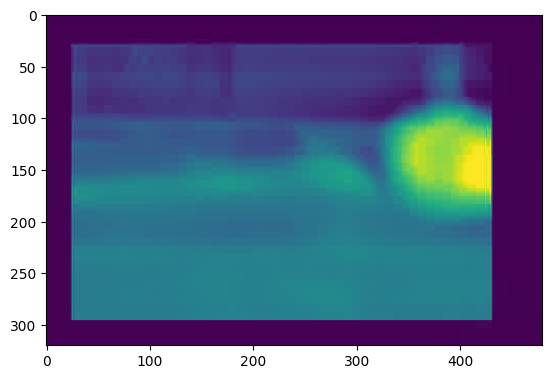

In [69]:
im_p = preprocessing(dataDir + path_list[451])
plt.imshow(im_p)
im_p.shape

In [70]:
def contours(img):
  img_v = img
  ret, thresh = cv2.threshold(img, 127, 255, 0)
  contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  cont = cv2.drawContours(img, contours, -1, (255,255,0), 1)
  rect = []
  box = []
  for c in contours:
    approx = cv2.approxPolyDP(c, .05*cv2.arcLength(c, True), True)
    if len(approx) == 4 and cv2.arcLength(c, True) >= .025 * img.shape[1]:
      x, y, w, h = cv2.boundingRect(c)
      rect.append([x, y, w, h])
      box.append([x, y, x+w, y+h])
      for r in rect:
        pic = cv2.rectangle(cont, (r[0], r[1]), (r[0]+r[2], r[1]+r[3]), (0,255,255), 1)
    else:
      pic = img_v
  return pic, box

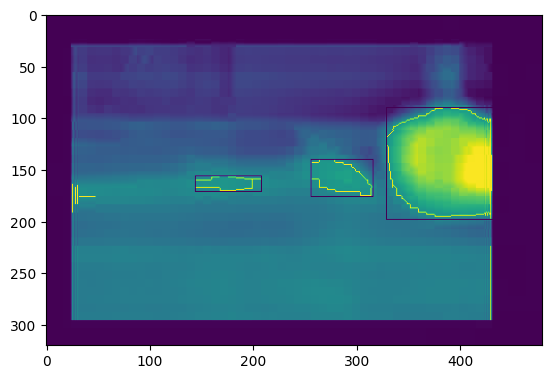

In [71]:
pic, box = contours(im_p)
plt.imshow(pic)

## Функция для обрезки изображния по ячейкам

In [55]:
def cut(img, rectangles: list):
  cells = []
  fire = 0
  for r in rectangles:
    cell = img[r[1]:r[3], r[0]:r[2]]
    cells.append(cell)
    plt.imshow(cell)
    plt.show()
    br = cell.sum() / (cell.shape[0] * cell.shape[1])
    print(br)
    if br > ALARM:
      fire += 1
  return len(cells)

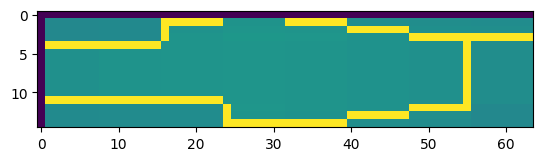

133.94479166666667


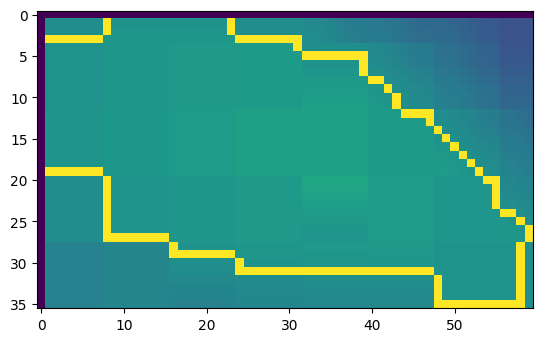

130.02407407407406


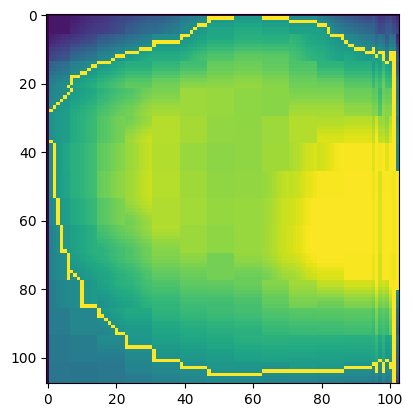

180.5715569938871


3

In [72]:
cut(im_p, box)

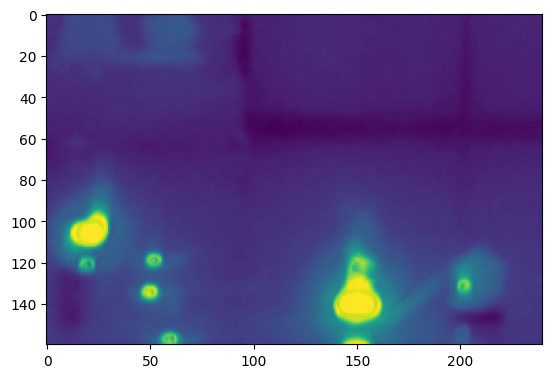

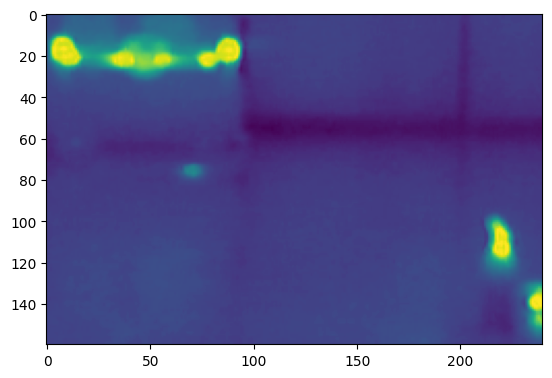

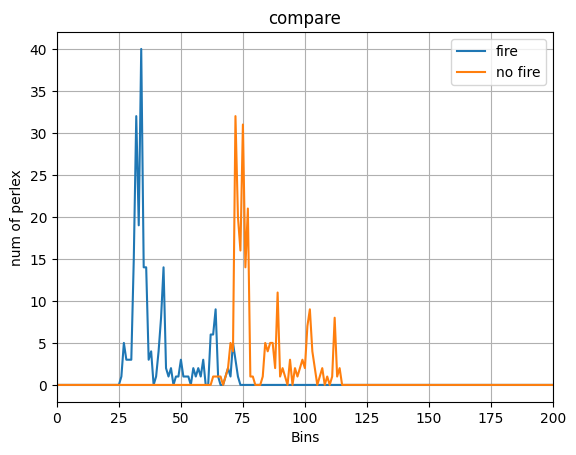

In [ ]:
img_true = cv2.imread((dataDir + descr['file'][3]), cv2.IMREAD_GRAYSCALE)[int(h/3):int(2*h/3), int(w/3):int(2*w/3)]
img_false = cv2.imread((dataDir + descr['file'][17]), cv2.IMREAD_GRAYSCALE)[int(h/3):int(2*h/3), int(w/3):int(2*w/3)]
hist_t = cv2.calcHist(img_true, [0], None, [256], [0, 256])
hist_f = cv2.calcHist(img_false, [0], None, [256], [0, 256])
plt.imshow(img_true)
plt.show()
plt.imshow(img_false)
plt.show()
plt.title("compare")
plt.xlabel("Bins")
plt.ylabel("num of perlex")
plt.plot(hist_t)
plt.plot(hist_f)
plt.xlim([0, 200])
plt.grid()
plt.legend(('fire', 'no fire'))
plt.show()

In [ ]:
"""MIT License

Copyright (c) 2019

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE."""

import serial, time
import datetime as dt
import numpy as np
import cv2

# function to get Emissivity from MCU
def get_emissivity():
	ser.write(serial.to_bytes([0xA5,0x55,0x01,0xFB]))
	read = ser.read(4)
	return read[2]/100

# function to get temperatures from MCU (Celsius degrees x 100)
def get_temp_array(d):

	# getting ambient temperature
	T_a = (int(d[1540]) + int(d[1541])*256)/100

	# getting raw array of pixels temperature
	raw_data = d[4:1540]
	T_array = np.frombuffer(raw_data, dtype=np.int16)

	return T_a, T_array

# function to convert temperatures to pixels on image
def td_to_image(f):
	norm = np.uint8((f/100 - Tmin)*255/(Tmax-Tmin))
	norm.shape = (24,32)
	return norm

########################### Main cycle #################################
# Color map range
Tmax = 40
Tmin = 20

print ('Configuring Serial port')
ser = serial.Serial ('/dev/serial0')
ser.baudrate = 115200

# set frequency of module to 4 Hz
ser.write(serial.to_bytes([0xA5,0x25,0x01,0xCB]))
time.sleep(0.1)

# Starting automatic data colection
ser.write(serial.to_bytes([0xA5,0x35,0x02,0xDC]))
t0 = time.time()

try:
	while True:
		# waiting for data frame
		data = ser.read(1544)

		# The data is ready, let's handle it!
		Ta, temp_array = get_temp_array(data)
		ta_img = td_to_image(temp_array)

		# Image processing
		img = cv2.applyColorMap(ta_img, cv2.COLORMAP_JET)
		img = cv2.resize(img, (320,240), interpolation = cv2.INTER_CUBIC)
		img = cv2.flip(img, 1)

		text = 'Tmin = {:+.1f} Tmax = {:+.1f} FPS = {:.2f}'.format(temp_array.min()/100, temp_array.max()/100, 1/(time.time() - t0))
		cv2.putText(img, text, (5, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 0), 1)
		cv2.imshow('Output', img)

		# if 's' is pressed - saving of picture
		key = cv2.waitKey(1) & 0xFF
		if key == ord("s"):
			fname = 'pic_' + dt.datetime.now().strftime('%Y-%m-%d_%H-%M-%S') + '.jpg'
			cv2.imwrite(fname, img)
			print('Saving image ', fname)

		t0 = time.time()

except KeyboardInterrupt:
	# to terminate the cycle
	ser.write(serial.to_bytes([0xA5,0x35,0x01,0xDB]))
	ser.close()
	cv2.destroyAllWindows()
	print(' Stopped')

# just in case
ser.close()
cv2.destroyAllWindows()